In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.models as models

from utils.utils import *
from sklearn.model_selection import train_test_split
import pickle

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# Define ResNet50 architecture in PyTorch
resnet50 = models.resnet50(weights='IMAGENET1K_V1')

# Freeze ResNet50 layers
# for param in resnet50.parameters():
#     param.requires_grad = False

# Modify the fully connected layers
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 3)
)

# The model is ready
model = resnet50.to(device)

In [40]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
total_params = count_parameters(model)
print("Total trainable parameters: ", total_params)

Total trainable parameters:  24729795


In [42]:
NUM_EPOCHS = 100
BATCH_SIZE = 16

In [43]:
benign_images, benign_masks = read_data(directory = "data//benign", target_size=(256, 256))
normal_images, normal_masks = read_data(directory = "data//normal", target_size=(256, 256))
malignant_images, malignant_masks = read_data(directory = "data//malignant", target_size=(256, 256))

benign_masks = np.reshape(benign_masks, (benign_masks.shape[0], 1, benign_masks.shape[1], benign_masks.shape[2]))
normal_masks = np.reshape(normal_masks, (normal_masks.shape[0], 1, normal_masks.shape[1], normal_masks.shape[2]))
malignant_masks = np.reshape(malignant_masks, (malignant_masks.shape[0], 1, malignant_masks.shape[1], malignant_masks.shape[2]))

benign_images = np.transpose(benign_images, (0, 3, 1, 2))
normal_images = np.transpose(normal_images, (0, 3, 1, 2))
malignant_images = np.transpose(malignant_images, (0, 3, 1, 2))

benign_values = np.array([1, 0, 0], dtype = np.float32)
normal_values = np.array([0, 1, 0], dtype = np.float32)
malignant_values = np.array([0, 0, 1], dtype = np.float32)
num_benign = len(benign_images)
num_normal = len(normal_images)
num_malignant = len(malignant_images)
y_classification = []
X = []

for i in range(num_benign):
    y_classification.append(benign_values)
for i in range(num_normal):
    y_classification.append(normal_values)
for i in range(num_malignant):
    y_classification.append(malignant_values)
y_classification = np.array(y_classification, dtype = np.float32)

benign_masks[benign_masks>0] = 1
normal_masks[normal_masks>0] = 1
malignant_masks[malignant_masks>0] = 1
benign_images = benign_images.astype(dtype = np.float32)
normal_images = normal_images.astype(dtype = np.float32)
malignant_images = malignant_images.astype(dtype = np.float32)
benign_images /= 255
normal_images /= 255
malignant_images /= 255

for img in benign_images:
    X.append(img)
for img in normal_images:
    X.append(img)
for img in malignant_images:
    X.append(img)
X = np.array(X, dtype=np.float32)

num_samples = len(y_classification)
perm = np.random.permutation(num_samples)

X = X[perm]
y_classification = y_classification[perm]

total_samples = len(X)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)

X_train = X[:train_size]
y_classification_train = y_classification[:train_size]

X_val = X[train_size:train_size + val_size]
y_classification_val = y_classification[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_classification_test = y_classification[train_size + val_size:]

In [44]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [45]:
X_train = torch.Tensor(X_train).to(device)
y_classification_train = torch.Tensor(y_classification_train).to(device)

X_val = torch.Tensor(X_val).to(device)
y_classification_val = torch.Tensor(y_classification_val).to(device)

X_test = torch.Tensor(X_test).to(device)
y_classification_test = torch.Tensor(y_classification_test).to(device)

train_dataset = CustomDataset(X_train, y_classification_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataset = CustomDataset(X_val, y_classification_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = CustomDataset(X_test, y_classification_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
y_classification.shape

(780, 3)

In [47]:
model.train()

optimizer = Adam(model.parameters(), lr = 0.001, betas=[0.9, 0.999])
classification_loss = nn.CrossEntropyLoss()

classification_loss_train = []
classification_loss_val = []
classification_loss_test = []
accuracy_list = []

for i in range(NUM_EPOCHS):
    model.train()
    train_loss_class = []
    train_loss_seg = []
    val_loss_class = []
    val_loss_seg = []
    test_loss_class = []
    test_loss_seg = []
    accuracy = []

    for batch in train_loader:
        X_data, y_class = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        classification_output = model(X_data)
        classification_output = torch.softmax(classification_output, dim=1)
        class_loss = classification_loss(classification_output, y_class)
        class_loss.backward()
        optimizer.step()
        train_loss_class.append(class_loss.item())
        predicted_classes = torch.argmax(classification_output, dim=1)
        temp_class = torch.argmax(y_class, dim=1)
        accuracy.append((predicted_classes == temp_class).float().mean().item())

    accuracy = sum(accuracy)/len(accuracy)
    accuracy_list.append(accuracy)
    classification_loss_train.append(sum(train_loss_class) / len(train_loss_class))

    model.eval()
    with torch.no_grad():
        val_loss_class = []
        for batch in val_loader:
            X_val, y_class_val = batch[0].to(device), batch[1].to(device)
            classification_output_val = model(X_val)
            classification_output_val = torch.softmax(classification_output_val, dim=1)
            class_loss_val = classification_loss(classification_output_val, y_class_val)
            val_loss_class.append(class_loss_val.item())
        
        classification_loss_val.append(sum(val_loss_class) / len(val_loss_class))
    
    with torch.no_grad():
        test_loss_class = []
        test_loss_seg = []
        for batch in test_loader:
            X_test, y_class_test = batch[0].to(device), batch[1].to(device)
            classification_output_test = model(X_test)
            classification_output_test = torch.softmax(classification_output_test, dim=1)
            class_loss_test = classification_loss(classification_output_test, y_class_test)
            test_loss_class.append(class_loss_test.item())
        
        classification_loss_test.append(sum(test_loss_class) / len(test_loss_class))

    print(f"Epoch: {i}, Classification Training Loss: {classification_loss_train[-1]}, Train accuracy: {accuracy_list[-1]}, Classification Validation Loss: {classification_loss_val[-1]}, Classification Test Loss: {classification_loss_test[-1]},")


Epoch: 0, Classification Training Loss: 0.9758976289204189, Train accuracy: 0.5589285714285714, Classification Validation Loss: 0.9632477641105652, Classification Test Loss: 0.9610772609710694,
Epoch: 1, Classification Training Loss: 0.9723303743771144, Train accuracy: 0.5660714285714286, Classification Validation Loss: 1.0097781240940094, Classification Test Loss: 1.0050162315368651,
Epoch: 2, Classification Training Loss: 0.9242807643754142, Train accuracy: 0.5660714285714286, Classification Validation Loss: 1.0097781240940094, Classification Test Loss: 1.0050162315368651,
Epoch: 3, Classification Training Loss: 0.9243875162942069, Train accuracy: 0.5678571428571428, Classification Validation Loss: 0.9528986871242523, Classification Test Loss: 0.9644190549850464,
Epoch: 4, Classification Training Loss: 0.9253892506871905, Train accuracy: 0.6017857142857143, Classification Validation Loss: 0.9483139336109161, Classification Test Loss: 0.9372375726699829,
Epoch: 5, Classification Train

In [48]:
torch.save(model.state_dict(), 'res50.pth')

In [55]:
lists_to_save = {
    'classification_loss_train': classification_loss_train,
    'classification_loss_val': classification_loss_val,
    'classification_loss_test': classification_loss_test,
    'accuracy': accuracy_list
}

with open('res50_results_1.pkl', 'wb') as f:
    pickle.dump(lists_to_save, f)

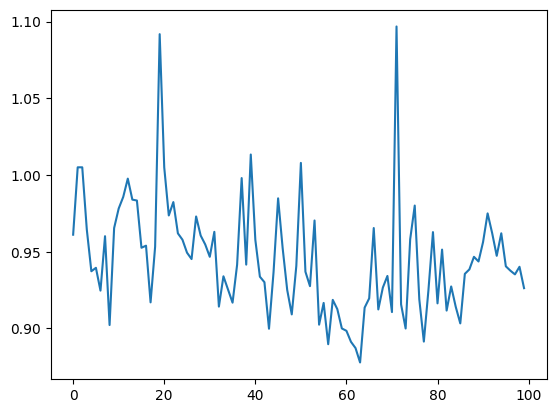

In [51]:
plt.plot(classification_loss_test)
plt.show()

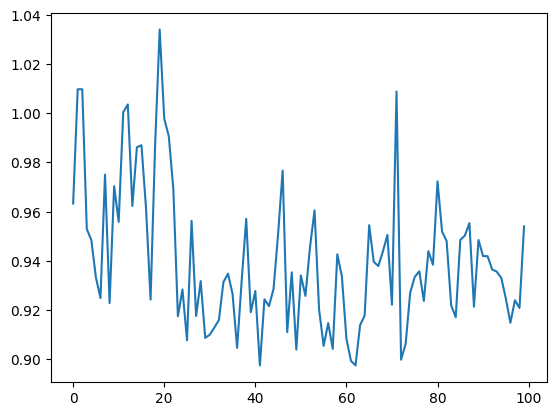

In [52]:
plt.plot(classification_loss_val)
plt.show()

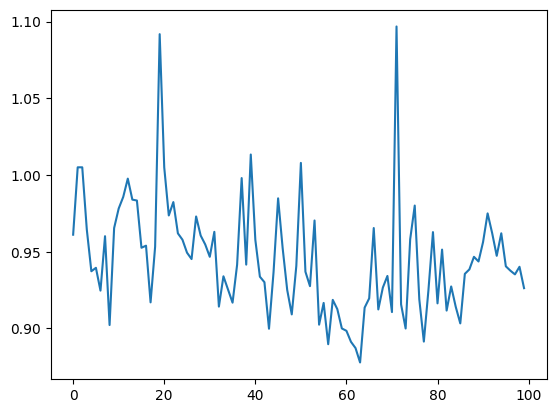

In [53]:
plt.plot(classification_loss_test)
plt.show()

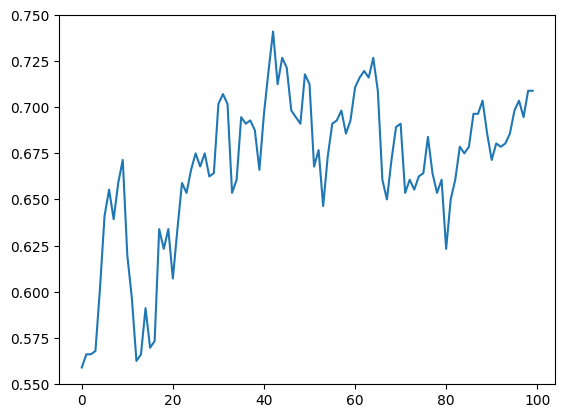

In [54]:
plt.plot(accuracy_list)
plt.show()

In [57]:
import pickle

pickle_file_path = "res50_results_1.pkl"

with open(pickle_file_path, "rb") as f:
    data = pickle.load(f)

# data

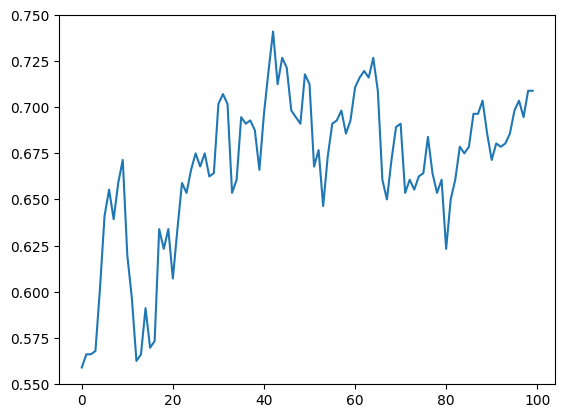

In [59]:
# plt.plot(data["accuracy"])
# plt.show()